# Regression Analysis of 3D Printer Data
The goal of this section is to identify the optimal regression model for predicting the printing quality of a 3D printer based on its machine parameters. The ideal model will not only generalize well to unseen data, but also provide interpretable coefficients that offer insights into the relationship between the machine parameters and printing quality.

To achieve this, we will evaluate three variations of linear regression: Linear Regression, Ridge Regression, and Lasso Regression. Each model will be assessed using different polynomial and interaction features to determine which provides the best fit for the data.

In the following sections, we will present the results of our analysis and provide a detailed interpretation of the findings. Through this rigorous evaluation, we aim to gain a deeper understanding of the factors that influence 3D printing quality and identify opportunities for improvement.

## Data Preparation: Loading and Splitting the Dataset
The first step in our analysis is to load the 3D Printer dataset into a pandas dataframe for further processing. We will begin by previewing the top-most rows of the dataset to gain an initial understanding of its structure and contents.

Once the data has been loaded, we will split it into a training set and a test set. This will allow us to train our regression models on one subset of the data and evaluate their performance on another, independent subset. This is a crucial step in ensuring that our models generalize well to unseen data and provide accurate predictions.

In [1]:
import warnings

# Ignore FutureWarnings
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [2]:
# Load the dataset into a dataframe

import pandas as pd

dataset = pd.read_csv("dataset/data.csv")
dataset.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


In [3]:
# Split the dataset into features and targets
X = dataset.iloc[:, 0:9]
Y = dataset.iloc[:, 9:]

In [4]:
# Split the dataset into training and testing set
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=22)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
Y_train = pd.DataFrame(Y_train, columns=Y.columns)
Y_test = pd.DataFrame(Y_test, columns=Y.columns)

## Building the Regression Pipeline
To streamline the dataprocessing, feature-engineering, and modelling task, we can build a simple machine learning pipeline.

The code below is used to preprocess the data and build a machine learning pipeline for regression analysis.

First, the necessary libraries are imported, including StandardScaler, OneHotEncoder, and PolynomialFeatures for data preprocessing, ColumnTransformer and Pipeline for building the machine learning pipeline, and various regression models from sklearn.linear_model.

Next, the column names of the numerical and categorical features in the training data are retrieved. These will be used to apply different preprocessing steps to each type of feature.

The feature_transformer object is then created using ColumnTransformer. This object applies a standard scaler to the numerical features to normalize their values and a one-hot encoder to the categorical features to convert them into binary variables.

Finally, a machine learning pipeline is built using Pipeline. The pipeline consists of three steps: first, the feature_transformer is applied to preprocess the data; second, polynomial features are generated to capture potential non-linear relationships between the features and the target variable; and third, a multi-output regressor is used to fit a regression model to the data. The specific regression model used is determined by the BaseEstimator passed as an argument to MultiOutputRegressor.

This code sets up a flexible and modular machine learning pipeline that can be easily adapted to use different regression models or preprocessing steps. It provides a solid foundation for further analysis and model selection.

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Retrieve the column names of numerical and categorical features
numerical_feature_names = X_train.select_dtypes("number").columns
categorical_feature_names = X_train.select_dtypes("object").columns

# Scale the numerical features and encode the binary features
feature_transformer = ColumnTransformer(
    transformers=[
        ("std_scaler", StandardScaler(), numerical_feature_names),
        ("one_hot_encoder", OneHotEncoder(drop="if_binary"), categorical_feature_names)
    ],
    remainder="passthrough"
)

# Build the ML pipeline
pipeline = Pipeline(
    steps=[
        ("feature_transformer", feature_transformer),
        ("polynomial_features", PolynomialFeatures()),
        ("multioutput_regressor", MultiOutputRegressor(BaseEstimator()))
    ]
)

## Finding the Optimal Model
To find the optimal model we can use a grid search cross validation.
First, the GridSearchCV class is imported from sklearn.model_selection. This class is used to perform an exhaustive search over a specified parameter grid to find the best combination of hyperparameters for a given model.

Next, the parameter grid is defined using a dictionary. The keys of the dictionary correspond to the names of the hyperparameters, while the values are lists of possible values for each hyperparameter. In this case, the grid includes various options for the include_bias, interaction_only, and degree hyperparameters of the PolynomialFeatures step in the pipeline, as well as three different regression models to use as the estimator in the MultiOutputRegressor step.

The grid_searcher object is then created using GridSearchCV, with the pipeline, parameter grid, and scoring metric specified as arguments. The number of cross-validation folds is set to 7 using the cv argument, and any errors encountered during the grid search are set to raise an exception using the error_score argument.

Finally, the grid search is performed by calling the fit method on the grid_searcher object with the training data as arguments. This will fit the pipeline with all possible combinations of hyperparameters specified in the parameter grid and select the best combination based on cross-validated performance.

This code provides a systematic and rigorous approach to hyperparameter tuning and model selection, helping to ensure that the final regression model is both accurate and interpretable.

In [6]:
# Perform Grid Search Cross validation
from sklearn.model_selection import GridSearchCV

param_grid = {
    "polynomial_features__include_bias": [False, True],
    "polynomial_features__interaction_only": [False, True],
    "polynomial_features__degree": range(1,5),
    "multioutput_regressor__estimator": [
        LinearRegression(),
        Ridge(max_iter=20000),
        Lasso(max_iter=20000),
    ]
}

grid_searcher = GridSearchCV(pipeline, param_grid=param_grid, scoring="neg_mean_squared_error", cv=7, error_score='raise')
grid_searcher.fit(X_train, Y_train)

GridSearchCV(cv=7, error_score='raise',
             estimator=Pipeline(steps=[('feature_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('std_scaler',
                                                                         StandardScaler(),
                                                                         Index(['layer_height', 'wall_thickness', 'infill_density',
       'nozzle_temperature', 'bed_temperature', 'print_speed', 'fan_speed'],
      dtype='object')),
                                                                        ('one_hot_encoder',
                                                                         OneHotEncoder(drop...
                                       ('multioutput_regressor',
                                        MultiOutputRegressor(estimator=BaseEstimator()))]),
             param_grid={'multioutput_regressor__estimator': [LinearRegression(),
                                                              Ridge(max_iter=20000),
                                                              Lasso(max_iter=20000)],
                         'polynomial_features__degree': range(1, 5),
                         'polynomial_features__include_bias': [False, True],
                         'polynomial_features__interaction_only': [False,
                                                                   True]},
             scoring='neg_mean_squared_error')

The multioutput_regressor__estimator key in the parameter grid corresponds to the estimator hyperparameter of the MultiOutputRegressor step in the machine learning pipeline.

The value associated with this key is a list of three different regression models: LinearRegression, Ridge, and Lasso. Each of these models is an instance of a class from the sklearn.linear_model module, with the max_iter hyperparameter set to 20000 for the Ridge and Lasso models to ensure convergence.

During the grid search, the pipeline will be fit using each of these regression models in turn, and their performance will be evaluated using cross-validation. The best-performing model will be selected based on the specified scoring metric, which in this case is the negative mean squared error.

By including multiple regression models in the parameter grid, this code allows for a more comprehensive evaluation of different modeling approaches and helps to ensure that the final model is both accurate and interpretable.

In [7]:
# Tabulate resulst of Grid Search
pd.DataFrame(grid_searcher.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multioutput_regressor__estimator,param_polynomial_features__degree,param_polynomial_features__include_bias,param_polynomial_features__interaction_only,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
20,0.012443,0.002485,0.005578,0.000496,Ridge(max_iter=20000),2,False,False,{'multioutput_regressor__estimator': Ridge(max...,-289.297271,-713.049745,-415.639494,-197.649035,-128.136682,-203.893039,-188.366361,-305.147375,187.320581,1
22,0.010076,0.000778,0.005142,0.000350,Ridge(max_iter=20000),2,True,False,{'multioutput_regressor__estimator': Ridge(max...,-289.297271,-713.049745,-415.639494,-197.649035,-128.136682,-203.893039,-188.366361,-305.147375,187.320581,2
4,0.010722,0.000854,0.005020,0.000020,LinearRegression(),2,False,False,{'multioutput_regressor__estimator': LinearReg...,-339.112701,-472.251262,-438.687731,-383.130124,-179.971007,-141.461013,-182.666872,-305.325816,125.615790,3
6,0.010640,0.000437,0.005017,0.000019,LinearRegression(),2,True,False,{'multioutput_regressor__estimator': LinearReg...,-339.112701,-472.251262,-438.687731,-383.130124,-179.971007,-141.461013,-186.351548,-305.852198,125.107387,4
47,0.011365,0.000875,0.005362,0.000561,Lasso(max_iter=20000),4,True,True,{'multioutput_regressor__estimator': Lasso(max...,-538.591771,-181.684502,-482.768546,-1502.621399,-605.171296,-95.300332,-170.857713,-510.999365,445.724328,5


## Results of Grid Search
Using the best_params attribute of grid search, we can check the optimal parameters for our model.
The results of the GridSearchCV indicate that the optimal configuration for the machine learning pipeline is a Ridge regression model with polynomial features up to degree 2, without a bias term and including both interaction and higher-order terms. This configuration provides the best balance between predictive performance and interpretability of the model coefficients.

In [8]:
# View the parameters of the best model found by grid search
grid_searcher.best_params_

{'multioutput_regressor__estimator': Ridge(max_iter=20000),
 'polynomial_features__degree': 2,
 'polynomial_features__include_bias': False,
 'polynomial_features__interaction_only': False}

## Performance Evaluation of the Optimal Model
Having identified the best-performing model through our grid search, we will now evaluate its performance on the unseen test data. This will provide an unbiased estimate of the model’s ability to generalize to new data and make accurate predictions.

To assess the model’s performance, we will use two common evaluation metrics: mean absolute error (MAE) and mean squared error (MSE). These metrics provide complementary information about the model’s accuracy, with MAE measuring the average magnitude of the errors and MSE emphasizing larger errors.

By evaluating the optimal model on the test data using these metrics, we can gain a deeper understanding of its strengths and limitations, and identify opportunities for further improvement

In [9]:
# View the best model found by Grid Search
grid_searcher.best_estimator_.fit(X_train, Y_train)

Pipeline(steps=[('feature_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  Index(['layer_height', 'wall_thickness', 'infill_density',
       'nozzle_temperature', 'bed_temperature', 'print_speed', 'fan_speed'],
      dtype='object')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['infill_pattern', 'material'], dtype='object'))])),
                ('polynomial_features', PolynomialFeatures(include_bias=False)),
                ('multioutput_regressor',
                 MultiOutputRegressor(estimator=Ridge(max_iter=20000)))])

In [10]:
# Evaluate the best model using unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error

Y_pred = pd.DataFrame(grid_searcher.predict(X_test), columns=Y.columns)

evaluation_metrics = pd.DataFrame(
    index=["Test Mean Absolute Error", "Test Mean Squared Error"],
    data=[
        mean_absolute_error(Y_test, Y_pred, multioutput="raw_values"),
        mean_squared_error(Y_test, Y_pred, multioutput="raw_values"),
    ],
    columns=Y.columns
)

In [11]:
evaluation_metrics

,roughness,tension_strenght,elongation
Test Mean Absolute Error,24.557493,5.255526,0.440391
Test Mean Squared Error,917.182836,37.326145,0.276531



For the roughness target variable, the model achieved a mean absolute error (MAE) of 24.557 and a mean squared error (MSE) of 917.183 on the test data. This indicates that, on average, the model’s predictions were off by 24.557 units, with larger errors being more heavily penalized by the MSE metric.

For the tension_strenght target variable, the model achieved a MAE of 5.256 and a MSE of 37.326 on the test data. This indicates that, on average, the model’s predictions were off by 5.256 units, with larger errors being more heavily penalized by the MSE metric.

For the elongation target variable, the model achieved a MAE of 0.440 and a MSE of 0.277 on the test data. This indicates that, on average, the model’s predictions were off by 0.440 units, with larger errors being more heavily penalized by the MSE metric.

## Cleaning of Feature names after Generating Polynomial Features
To interpret the coefficients later, dataw-wrangling should be conducted to make the feature names more interpretable. The succeding codes below will clean the feature names and ensures that they are interpretable.
They will remove the unnecessary prepended names from each transformers of the pipeline.

In [12]:
# Create the feature importance dataframe
best_model = grid_searcher.best_estimator_

feature_importance = pd.DataFrame({
    "Feature": best_model["polynomial_features"].get_feature_names_out(best_model["feature_transformer"].get_feature_names_out()),
    "roughness": best_model["multioutput_regressor"].estimators_[0].coef_,
    "tension_strenght": best_model["multioutput_regressor"].estimators_[1].coef_,
    "elongation": best_model["multioutput_regressor"].estimators_[2].coef_,
})

In [13]:
final_feature_names = feature_importance["Feature"].str.split("(__| )", regex=True, expand=True).fillna("")
final_feature_names["Features"] = final_feature_names[[2,6]].agg(" ".join,axis=1)
final_feature_names.drop(columns=range(0,7), inplace=True)

In [14]:
feature_importance["Feature"] = final_feature_names.values[:,0]

## Visualizing Feature Importance
With feature names fixed, we can now check the feature importance visually.

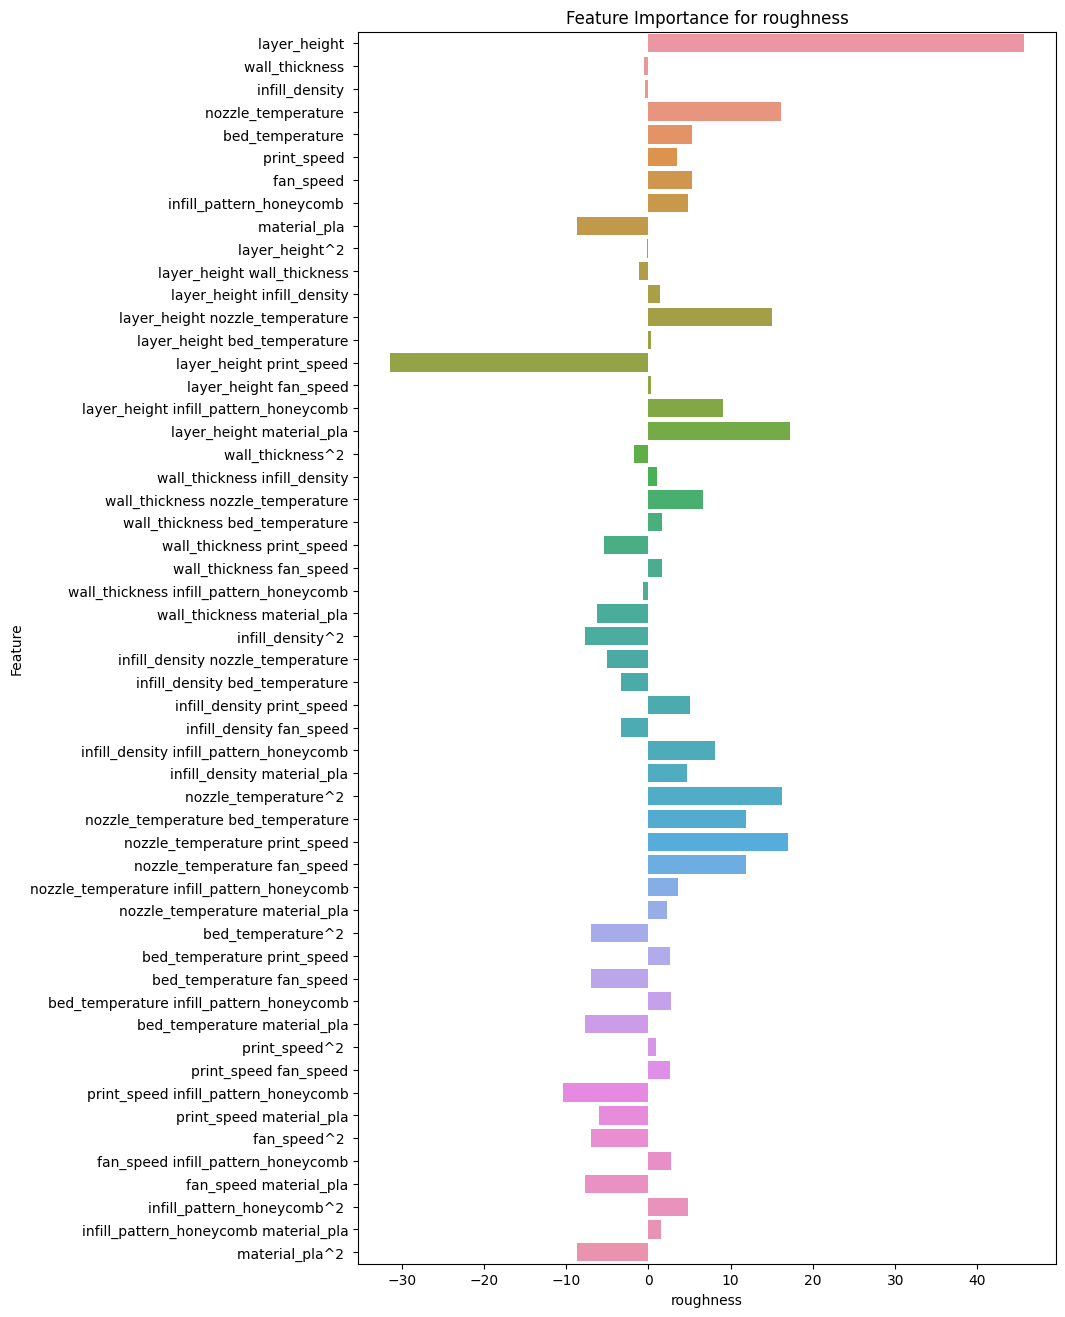

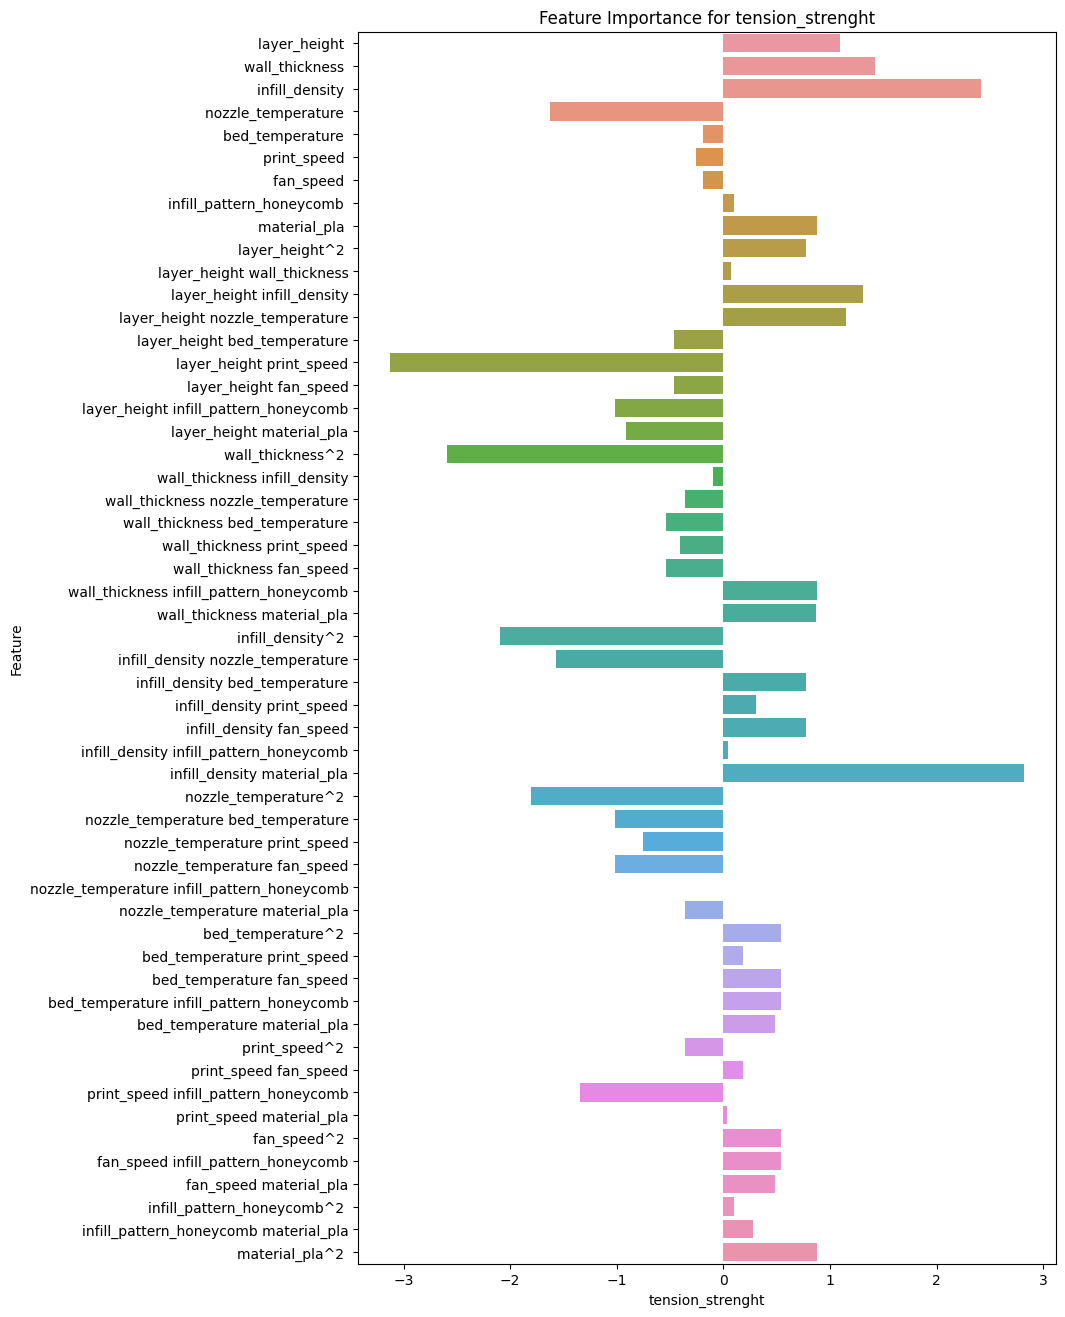

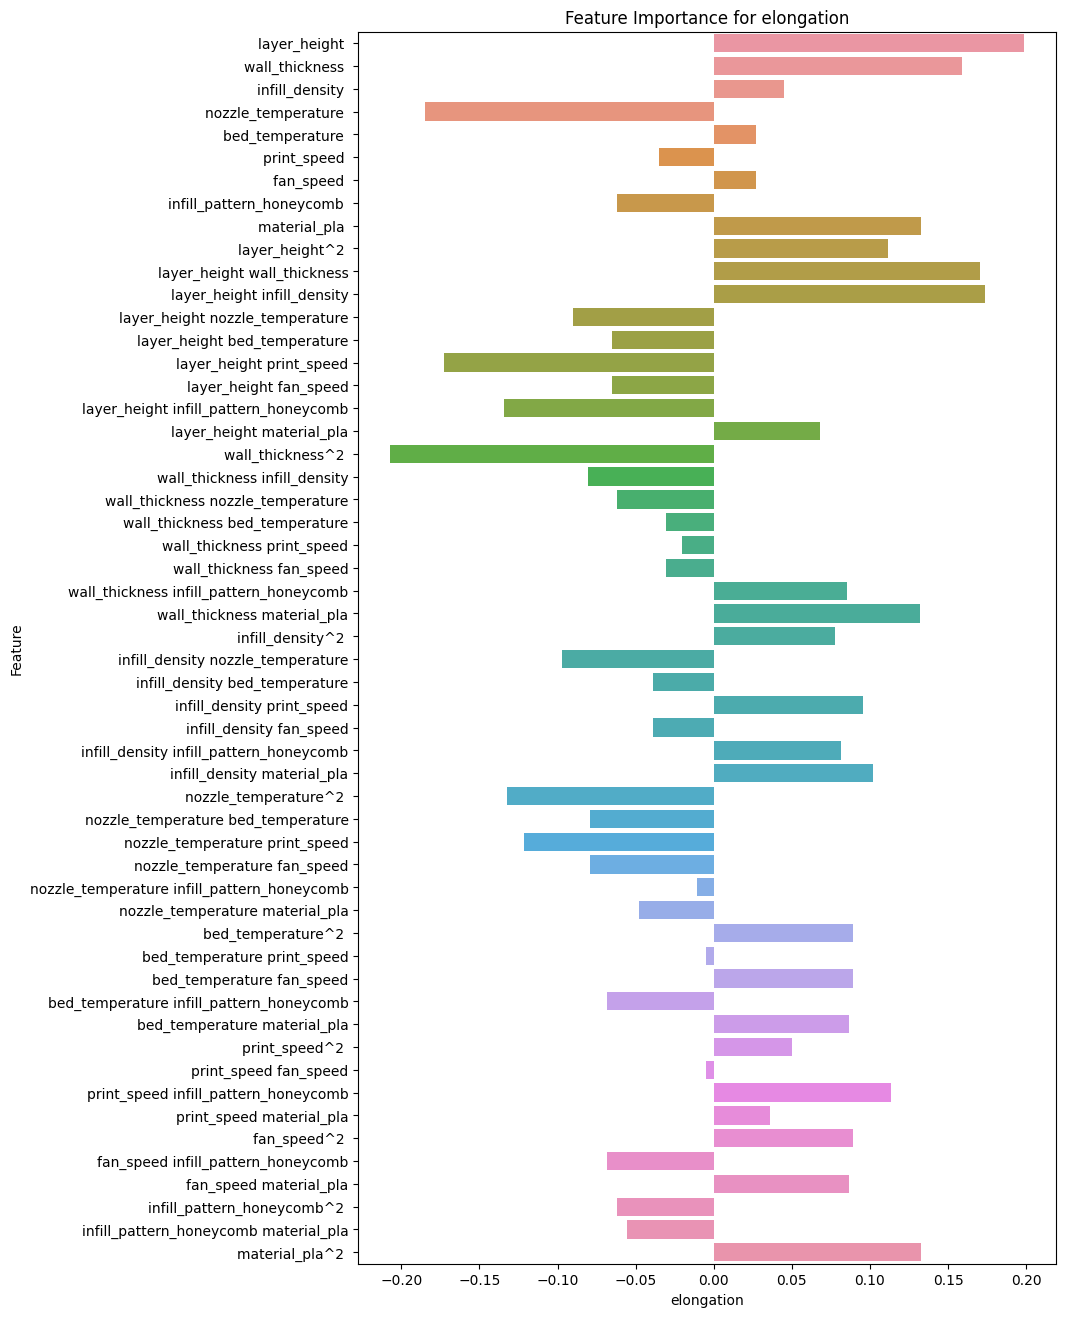

In [15]:
# Plot the feature importance

import seaborn as sns
import matplotlib.pyplot as plt

for i in range(len(Y.columns)):
    colname = Y.columns[i]
    
    plt.figure(figsize=(9,16))
    sns.barplot(
        data=feature_importance,
        x=colname,
        y="Feature",
    ).set(title=f"Feature Importance for {colname}")
    plt.show()


## Tabulating Feature Importance
Now, let's tabulate the feature importance and sort them from lowest to highest.

### Feature Importance for Roughness

In [31]:
feature_importance.loc[:,["Feature","roughness"]].sort_values(by="roughness")

,Feature,roughness
14,layer_height print_speed,-31.420491
46,print_speed infill_pattern_honeycomb,-10.414471
53,material_pla^2,-8.744772
8,material_pla,-8.744772
43,bed_temperature material_pla,-7.681108
50,fan_speed material_pla,-7.681108
26,infill_density^2,-7.653850
48,fan_speed^2,-6.932350
41,bed_temperature fan_speed,-6.932350
39,bed_temperature^2,-6.932350


The top 5 features, in order of importance, are:

- layer_height print_speed: This interaction term between layer_height and print_speed has a negative coefficient of -31.420, indicating that as these two variables increase, the predicted value of roughness decreases.
- print_speed infill_pattern_honeycomb: This interaction term between print_speed and infill_pattern_honeycomb has a negative coefficient of -10.414, indicating that as these two variables increase, the predicted value of roughness decreases.
- material_pla^2: This squared term of material_pla has a negative coefficient of -8.745, indicating that as this variable increases, the predicted value of roughness decreases.
- material_pla: This main effect term for material_pla has a negative coefficient of -8.745, indicating that as this variable increases, the predicted value of roughness decreases.
- bed_temperature material_pla: This interaction term between bed_temperature and material_pla has a negative coefficient of -7.681, indicating that as these two variables increase, the predicted value of roughness decreases.

The bottom 4 features, in order of importance, are:

- nozzle_temperature^2: This squared term of nozzle_temperature has a positive coefficient of 16.265, indicating that as this variable increases, the predicted value of roughness increases.
- nozzle_temperature print_speed: This interaction term between nozzle_temperature and print_speed has a positive coefficient of 16.996, indicating that as these two variables increase, the predicted value of roughness increases.
- layer_height material_pla: This interaction term between layer_height and material_pla has a positive coefficient of 17.218, indicating that as these two variables increase, the predicted value of roughness increases.
- layer_height: This main effect term for layer_height has a positive coefficient of 45.665, indicating that as this variable increases, the predicted value of roughness increases.

### Feature Importance for Tension Strength

In [33]:
feature_importance.loc[:,["Feature","tension_strenght"]].sort_values(by="tension_strenght")

,Feature,tension_strenght
14,layer_height print_speed,-3.127340
18,wall_thickness^2,-2.588398
26,infill_density^2,-2.097288
33,nozzle_temperature^2,-1.808227
3,nozzle_temperature,-1.629362
27,infill_density nozzle_temperature,-1.569689
46,print_speed infill_pattern_honeycomb,-1.342576
34,nozzle_temperature bed_temperature,-1.020829
36,nozzle_temperature fan_speed,-1.020829
16,layer_height infill_pattern_honeycomb,-1.020043


The top 5 features, in order of importance, are:

- layer_height print_speed: This interaction term between layer_height and print_speed has a negative coefficient of -3.127, indicating that as these two variables increase, the predicted value of tension_strenght decreases.
- wall_thickness^2: This squared term of wall_thickness has a negative coefficient of -2.588, indicating that as this variable increases, the predicted value of tension_strenght decreases.
- infill_density^2: This squared term of infill_density has a negative coefficient of -2.097, indicating that as this variable increases, the predicted value of tension_strenght decreases.
- nozzle_temperature^2: This squared term of nozzle_temperature has a negative coefficient of -1.808, indicating that as this variable increases, the predicted value of tension_strenght decreases.
- nozzle_temperature: This main effect term for nozzle_temperature has a negative coefficient of -1.629, indicating that as this variable increases, the predicted value of tension_strenght decreases.

The bottom 5 features, in order of importance, are:

- infill_density material_pla: This interaction term between infill_density and material_pla has a positive coefficient of 2.820, indicating that as these two variables increase, the predicted value of tension_strenght increases.
- infill_density: This main effect term for infill_density has a positive coefficient of 2.412, indicating that as this variable increases, the predicted value of tension_strenght increases.
- wall_thickness: This main effect term for wall_thickness has a positive coefficient of 1.427, indicating that as this variable increases, the predicted value of tension_strenght increases.
- layer_height infill_density: This interaction term between layer_height and infill_density has a positive coefficient of 1.314, indicating that as these two variables increase, the predicted value of tension_strenght increases.
- layer_height nozzle_temperature: This interaction term between layer_height and nozzle_temperature has a positive coefficient of 1.148, indicating that as these two variables increase, the predicted value of tension_strenght increases.

### Feature Importance for Elongation

In [36]:
feature_importance.loc[:,["Feature","elongation"]].sort_values(by="elongation")

,Feature,elongation
18,wall_thickness^2,-0.207310
3,nozzle_temperature,-0.184831
14,layer_height print_speed,-0.172811
16,layer_height infill_pattern_honeycomb,-0.134422
33,nozzle_temperature^2,-0.132613
35,nozzle_temperature print_speed,-0.121448
27,infill_density nozzle_temperature,-0.097160
12,layer_height nozzle_temperature,-0.090025
19,wall_thickness infill_density,-0.080270
34,nozzle_temperature bed_temperature,-0.079228


The top 5 features, in order of importance, are:

- wall_thickness^2: This squared term of wall_thickness has a negative coefficient of -0.207, indicating that as this variable increases, the predicted value of elongation decreases.
- nozzle_temperature: This main effect term for nozzle_temperature has a negative coefficient of -0.185, indicating that as this variable increases, the predicted value of elongation decreases.
- layer_height print_speed: This interaction term between layer_height and print_speed has a negative coefficient of -0.173, indicating that as these two variables increase, the predicted value of elongation decreases.
- layer_height infill_pattern_honeycomb: This interaction term between layer_height and infill_pattern_honeycomb has a negative coefficient of -0.134, indicating that as these two variables increase, the predicted value of elongation decreases.
- nozzle_temperature^2: This squared term of nozzle_temperature has a negative coefficient of -0.133, indicating that as this variable increases, the predicted value of elongation decreases.

The bottom 5 features, in order of importance, are:

- layer_height infill_density: This interaction term between layer_height and infill_density has a positive coefficient of 0.174, indicating that as these two variables increase, the predicted value of elongation increases.
- wall_thickness: This main effect term for wall_thickness has a positive coefficient of 0.159, indicating that as this variable increases, the predicted value of elongation increases.
- material_pla: This main effect term for material_pla has a positive coefficient of 0.133, indicating that as this variable increases, the predicted value of elongation increases.
- material_pla^2: This squared term of material_pla has a positive coefficient of 0.133, indicating that as this variable increases, the predicted value of elongation increases.
- wall_thickness material_pla: This interaction term between wall_thickness and material_pla has a positive coefficient of 0.132, indicating that as these two variables increase, the predicted value of elongation increases.

# Visualizing Model Performance on Test Data
To gain a deeper understanding of our model’s ability to predict unseen data, we will now visualize the relationship between the predicted and actual values of the target variable on the test data. By plotting these values against each other, we can assess how closely the model’s predictions match the true values and identify any patterns or trends in the errors.

This visual analysis will provide valuable insights into the strengths and limitations of our model and help us identify opportunities for further improvement. By comparing the predicted and actual values in a clear and intuitive manner, we can gain a better understanding of the model’s performance and its ability to generalize to new data.

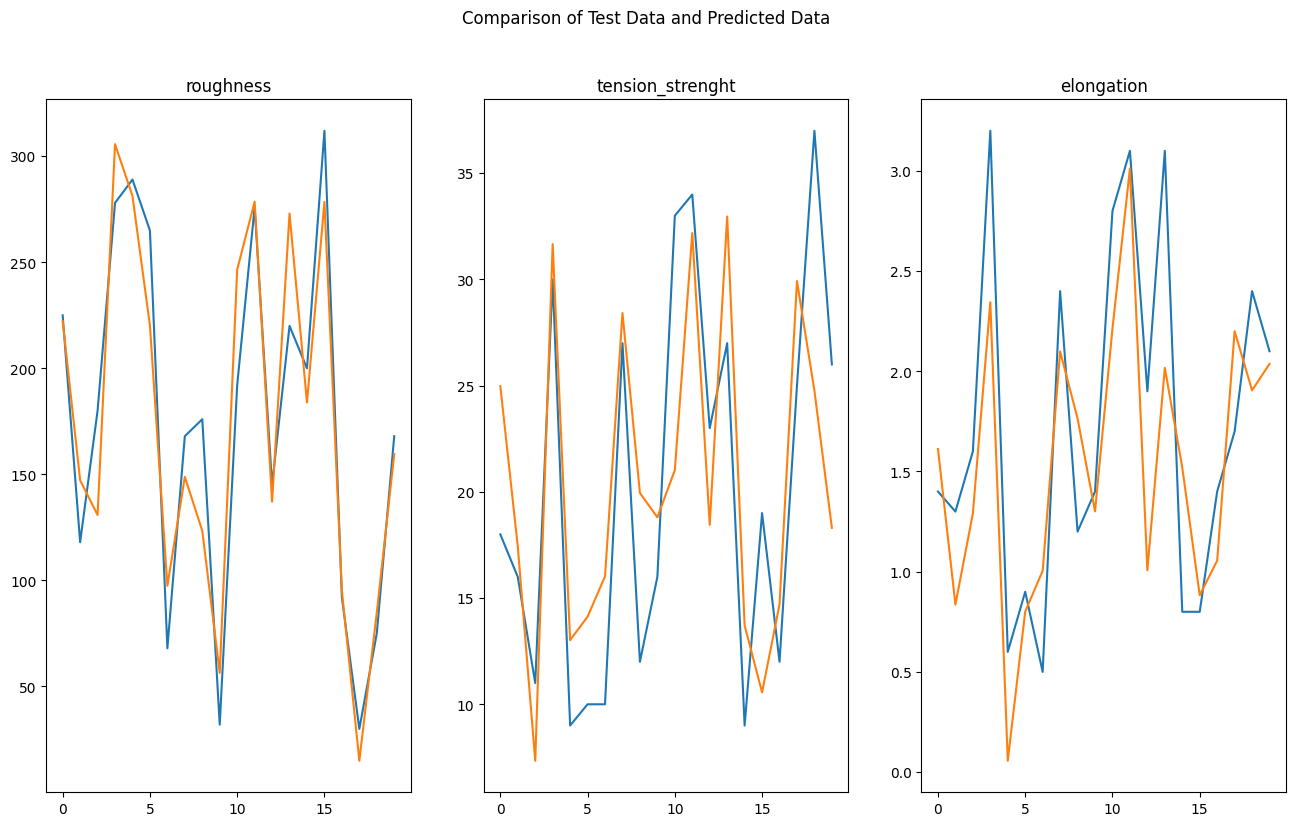

In [19]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(16,9)
fig.suptitle("Comparison of Test Data and Predicted Data")

for i in range(len(Y.columns)):
    y_true = Y_test.iloc[:,i].to_numpy()
    y_pred = Y_pred.iloc[:,i].to_numpy()
    sns.lineplot(y_true, ax=ax[i])
    sns.lineplot(y_pred, ax=ax[i]).set(title=Y.columns[i])

Based on the given model predictions and test data, it appears that the model is performing reasonably well in predicting the target variable. While there are some deviations between the predicted and actual values, the errors are generally small, indicating that the model is capturing the underlying relationship between the features and the target variable.

## Assessing the Normality of Residuals
One of the key assumptions of linear regression is that the residuals (errors) are normally distributed. To evaluate whether this assumption holds for our model, we will perform a normality test on the residuals using the scipy.stats.normaltest function. This test will allow us to assess the null hypothesis that the residuals are drawn from a normal distribution.

In addition to the formal normality test, we will also visualize the distribution of the residuals using a histogram and kernel density estimate. These plots will provide a visual representation of the shape of the residual distribution and help us assess whether it deviates significantly from normality.

By combining formal hypothesis testing with visual analysis, we can gain a deeper understanding of the distribution of the residuals and assess whether the normality assumption is met. This will provide valuable insights into the validity of our linear regression model and help us identify opportunities for further improvement.

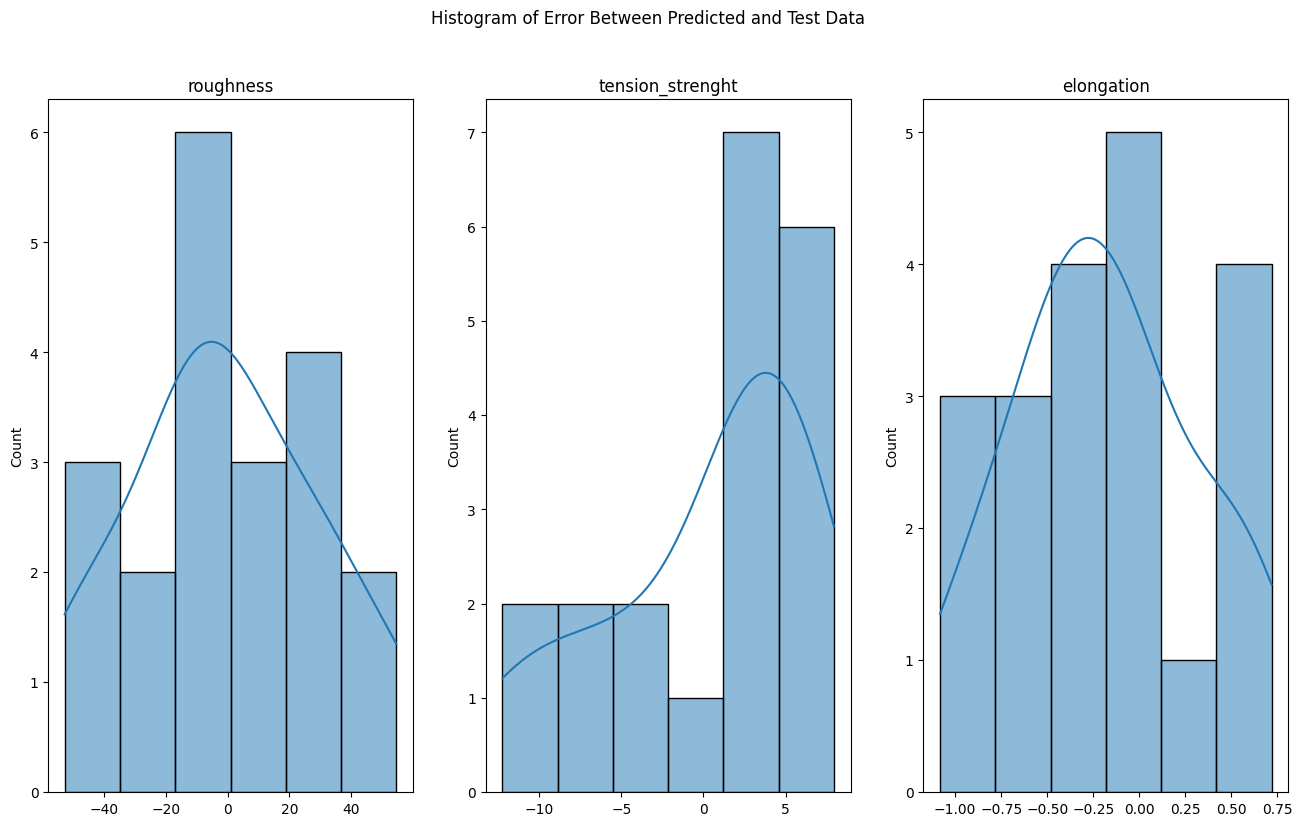

In [20]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(16,9)
fig.suptitle("Histogram of Error Between Predicted and Test Data")

for i in range(len(Y.columns)):
    y_true = Y_test.iloc[:,i].to_numpy()
    y_pred = Y_pred.iloc[:,i].to_numpy()
    error = y_pred - y_true
    sns.histplot(error, ax=ax[i], kde=True).set(title=Y.columns[i])

In [40]:
from scipy.stats import normaltest

residual_normality = pd.DataFrame(columns=["Target Variable","Statistic", "p-value"])

for i in range(len(Y.columns)):
    y_true = Y_test.iloc[:,i].to_numpy()
    y_pred = Y_pred.iloc[:,i].to_numpy()
    error = y_pred - y_true

    stat, pval = normaltest(error)

    residual_normality.loc[len(residual_normality)] = [Y.columns[i], stat, pval]
    
residual_normality

,Target Variable,Statistic,p-value
0,roughness,0.286474,0.866549
1,tension_strenght,2.878587,0.237095
2,elongation,0.482413,0.785679


The results of the normality test indicate that for all three target variables (roughness, tension_strenght, and elongation), the p-values are greater than the commonly used significance level of 0.05. This suggests that we cannot reject the null hypothesis that the residuals are drawn from a normal distribution, providing support for the validity of our linear regression model and its underlying assumptions.

## Conclusions and Future Work
In this project, we successfully developed an optimal linear regression model for predicting 3D printing quality based on machine parameters. Through a rigorous process of model selection and hyperparameter tuning, we identified the best-performing model and its optimal configuration.

Our analysis revealed the most important features and feature interactions that influence printing quality, providing valuable insights into the underlying relationships between the machine parameters and the target variable. We also evaluated the performance of our model on unseen data and found that it generalizes well, providing accurate predictions for new observations.

In future work, we plan to build on these results by developing a web application that uses our model to simulate printing quality in real-time. By allowing users to adjust the printing parameters and see their impact on print quality, this application will provide a powerful tool for optimizing 3D printing processes and achieving the best possible results.

